# Load and parse data with TensorFlow

In [22]:
from __future__ import absolute_import, division, print_function

import numpy as np
import random
import requests
import string
import tarfile
import tensorflow as tf

## Load Numpy Arrays

Build a data pipeline over numpy arrays.

In [2]:
# Create a toy dataset (even and odd numbers, with respective labels of 0 and 1).
evens = np.arange(0, 100, step=2, dtype=np.int32)
evens_label = np.zeros(50, dtype=np.int32)

odds = np.arange(1, 100, step=2, dtype=np.int32)
odds_label = np.ones(50, dtype=np.int32)

# Concatenate arrays
features = np.concatenate([evens, odds])
labels = np.concatenate([evens_label, odds_label])

print(features, type(features))
print(labels, type(labels))

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48
 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98
  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49
 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81 83 85 87 89 91 93 95 97 99] <class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'>


In [3]:
with tf.Graph().as_default():
    # Create TF session.
    sess = tf.Session()
    
    # Slice the numpy arrays (each row becoming a record).
    data = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Refill data indefinitely.  
    data = data.repeat()
    
    # Shuffle data.
    data = data.shuffle(buffer_size=100)

    # Batch data (aggregate records together).
    data = data.batch(batch_size=4)
    # Prefetch batch (pre-load batch for faster consumption).
    data = data.prefetch(buffer_size=1)
    
    # Create an iterator over the dataset.
    iterator = data.make_initializable_iterator()
    
    # Initialize the iterator.
    sess.run(iterator.initializer)

    # Get next data batch.
    d = iterator.get_next()

In [4]:
# Display data.
for i in range(10):
    x, y = sess.run(d)
    print(x, y)

[10 78 12 97] [0 0 0 1]
[17 71 28  0] [1 1 0 0]
[82 46 52 88] [0 0 0 0]
[38 19 22 53] [0 1 0 1]
[41  9 10  5] [1 1 0 1]
[24 16  7 92] [0 0 1 0]
[ 3 34 34 42] [1 0 0 0]
[91 69 93 11] [1 1 1 1]
[61 60  8 83] [1 0 0 1]
[47 73 90  2] [1 1 0 0]


## Load CSV files

Build a data pipeline from features stored in a CSV file. For this example, Titanic dataset will be used as a toy dataset stored in CSV format.


#### Titanic Dataset



survived|pclass|name|sex|age|sibsp|parch|ticket|fare
--------|------|----|---|---|-----|-----|------|----
1|1|"Allen, Miss. Elisabeth Walton"|female|29|0|0|24160|211.3375
1|1|"Allison, Master. Hudson Trevor"|male|0.9167|1|2|113781|151.5500
0|1|"Allison, Miss. Helen Loraine"|female|2|1|2|113781|151.5500
0|1|"Allison, Mr. Hudson Joshua Creighton"|male|30|1|2|113781|151.5500
...|...|...|...|...|...|...|...|...

In [8]:
# Load Titanic dataset.
# Original features: survived, pclass, name, sex, age, sibsp, parch, ticket, fare
# Select specific columns: survived,pclass,name,sex,age,fare
column_to_use = [0, 1, 2, 3, 4, 8]
record_defaults = [tf.int32, tf.int32, tf.string, tf.string, tf.float32, tf.float32]

In [1]:
with tf.Graph().as_default():
    # Create TF session.
    sess = tf.Session()
    
    # Load the whole dataset file, and slice each line.
    data = tf.data.experimental.CsvDataset("./titanic_dataset.csv", record_defaults, header=True, select_cols=column_to_use)
    # Refill data indefinitely.  
    data = data.repeat()
    # Shuffle data.
    data = data.shuffle(buffer_size=1000)
    # Batch data (aggregate records together).
    data = data.batch(batch_size=2)
    # Prefetch batch (pre-load batch for faster consumption).
    data = data.prefetch(buffer_size=1)
    
    # Create an iterator over the dataset.
    iterator = data.make_initializable_iterator()
    # Initialize the iterator.
    sess.run(iterator.initializer)

    # Get next data batch.
    d = iterator.get_next()

In [2]:
# Display data.
for i in range(3):
    survived, pclass, name, sex, age, fare = sess.run(d)
    print(survived)
    print(pclass)
    print(name)
    print(sex)
    print(age)
    print(fare)
    print("")

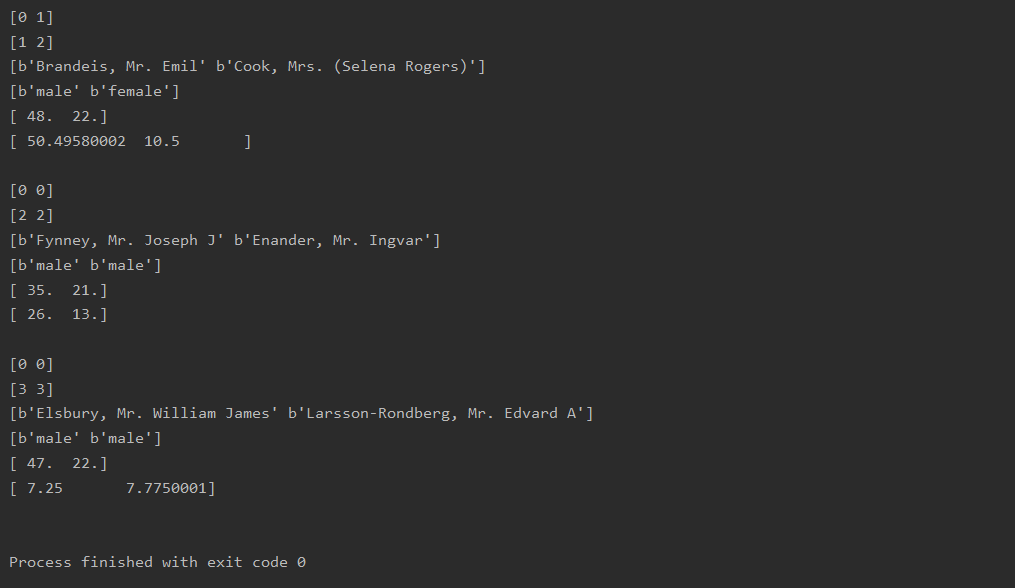

## Load Images

Build a data pipeline by loading images from disk. For this example, Oxford Flowers dataset will be used.


In [6]:
# # Download Oxford 17 flowers dataset.（已下载）
# d = requests.get("http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz")
# # 保存到本地
# with open("17flowers.tgz", "wb") as f:
#     f.write(d.content)
    
# Extract archive.（解压文件）
with tarfile.open("17flowers.tgz") as t:
    # 解压文件，在此样例中解压为一个名为jpg的文件夹，内含图片文件image_000X.jpg及文件列表files.txt
    t.extractall()

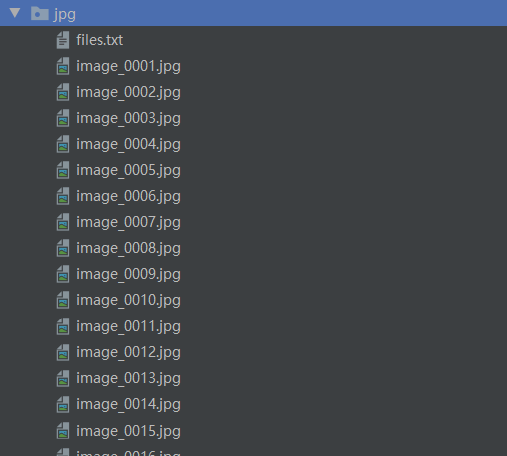

In [3]:
# Create a file to list all images path and their corresponding label.
with open('jpg/dataset.csv', 'w') as f:
    c = 0
    # 该数据集共1360个图像
    for i in range(1360):
        f.write("jpg/image_%04i.jpg,%i\n" % (i + 1, c))
        if (i + 1) % 80 == 0:
            c += 1

In [ ]:
with tf.Graph().as_default():
    # Load Images.
    with open("jpg/dataset.csv") as f:
        dataset_file = f.read().splitlines()

    # Create TF session.
    sess = tf.Session()

    # Load the whole dataset file, and slice each line.
    data = tf.data.Dataset.from_tensor_slices(dataset_file)
    # Refill data indefinitely.
    data = data.repeat()
    # Shuffle data.
    data = data.shuffle(buffer_size=1000)

    # Load and pre-process images.
    def load_image(path):
        # Read image from path.
        image = tf.io.read_file(path)
        # Decode the jpeg image to array [0, 255].
        image = tf.image.decode_jpeg(image)
        # Resize images to a common size of 256x256.
        image = tf.image.resize(image, [256, 256])
        # Rescale values to [-1, 1].
        image = 1. - image / 127.5
        return image

    # Decode each line from the dataset file.
    def parse_records(line):
        # File is in csv format: "image_path,label_id".
        # TensorFlow requires a default value, but it will never be used.
        image_path, image_label = tf.io.decode_csv(line, ["", 0])
        # Apply the function to load images.
        image = load_image(image_path)
        return image, image_label


    # Use 'map' to apply the above functions in parallel.num_threads = 4
    data = data.map(parse_records, num_parallel_calls=4)

    # Batch data (aggregate images-array together).
    data = data.batch(batch_size=2)
    # Prefetch batch (pre-load batch for faster consumption).
    data = data.prefetch(buffer_size=1)

    # Create an iterator over the dataset.
    iterator = data.make_initializable_iterator()
    # Initialize the iterator.
    sess.run(iterator.initializer)

    # Get next data batch.
    d = iterator.get_next()

In [ ]:
# Display data.
for i in range(1):
    batch_x, batch_y = sess.run(d)
    print(batch_x, batch_y)

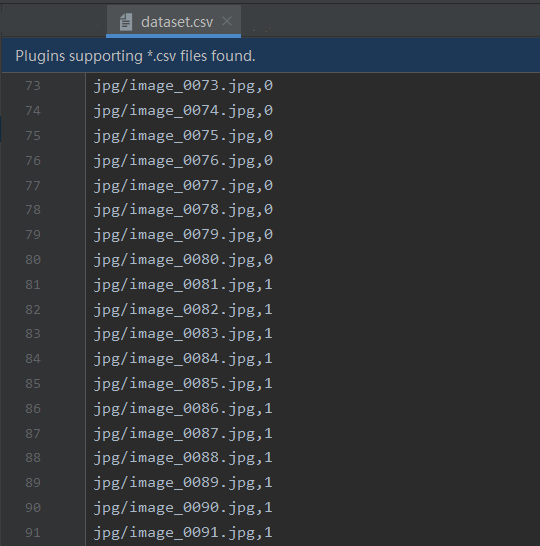

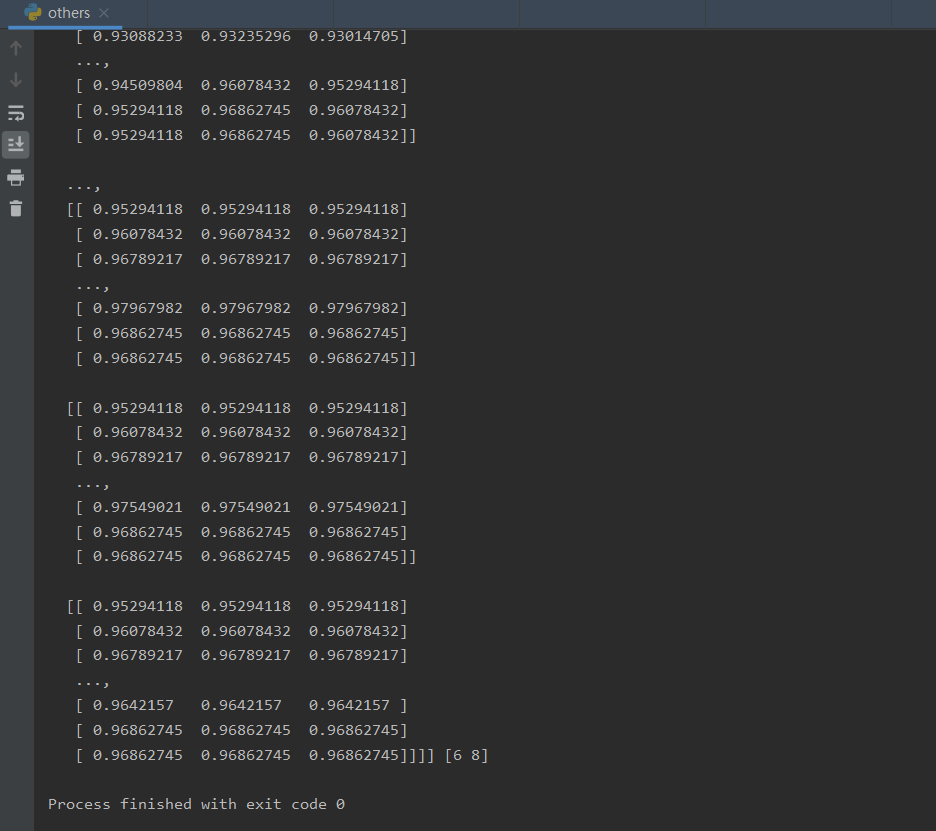

## Load data from a Generator

Build a data pipeline from a custom generator. For this example, a toy generator yielding random string, vector and it is used.


In [19]:
# Create a dummy（假） generator.
def generate_features():
    # Function to generate a random string.
    def random_string(length):
        return ''.join(random.choice(string.ascii_letters) for m in range(length))
    # Return a random string, a random vector, and a random int.
    yield random_string(4), np.random.uniform(size=4), random.randint(0, 10)

In [20]:
with tf.Graph().as_default():

    # Create TF session.
    sess = tf.Session()

    # Create TF dataset from the generator.
    data = tf.data.Dataset.from_generator(generate_features, output_types=(tf.string, tf.float32, tf.int32))
    # Refill data indefinitely.
    data = data.repeat()
    # Shuffle data.
    data = data.shuffle(buffer_size=100)
    # Batch data (aggregate records together).
    data = data.batch(batch_size=4)
    # Prefetch batch (pre-load batch for faster consumption).
    data = data.prefetch(buffer_size=1)

    # Create an iterator over the dataset.
    iterator = data.make_initializable_iterator()
    # Initialize the iterator.
    sess.run(iterator.initializer)

    # Get next data batch.
    d = iterator.get_next()

In [21]:
# Display data.    
for i in range(5):
    batch_str, batch_vector, batch_int = sess.run(d)
    print(batch_str, batch_vector, batch_int)

[b'UTjD' b'JdLs' b'KnOF' b'mntR'] [[ 0.78259504  0.56001276  0.28535196  0.11794931]
 [ 0.28031921  0.93185019  0.66735947  0.55340761]
 [ 0.45528886  0.32345957  0.79176462  0.69470835]
 [ 0.66970032  0.33096695  0.32577929  0.14728649]] [ 1  1 10  8]
[b'OKoG' b'FhwZ' b'fVVA' b'zPPy'] [[ 0.28711367  0.40140668  0.2010522   0.38584995]
 [ 0.54576731  0.77236605  0.17113256  0.98785007]
 [ 0.53226858  0.40044665  0.74331874  0.58194542]
 [ 0.1571068   0.58600026  0.76310164  0.17491864]] [3 1 0 2]
[b'yuGL' b'saFx' b'ArJD' b'RcYC'] [[ 0.33144012  0.52350724  0.94687009  0.96102142]
 [ 0.64164102  0.18993326  0.6000495   0.99285007]
 [ 0.93672115  0.62038237  0.49015608  0.79834557]
 [ 0.96753198  0.79601496  0.73656219  0.91291642]] [ 5 10  8  0]
[b'oerU' b'iPoz' b'iWSM' b'RcUP'] [[ 0.50542915  0.50221163  0.8511253   0.76720494]
 [ 0.11651734  0.71898025  0.46557361  0.07477511]
 [ 0.82277888  0.28086096  0.20106734  0.65075392]
 [ 0.03463646  0.41300511  0.100385    0.35186979]] [8 7 4